In [1]:
# Import packages

from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdpas_opened
from funcs_mrcio import irdsec_opened
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as sfft
import time
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
import pyfftw
import multiprocessing
import os
from tqdm import tqdm
import time
from PIL import Image
from scipy.optimize import curve_fit

In [2]:
# Importing the library
import psutil

# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 16.8
RAM Used (GB): 5.10240768


In [3]:
os.chdir('/home/rkarimi/saxtal/motion_correction_average')
big_array = np.load('SFO2_100_0001/frame_stack_float32.npy')

In [4]:
# Perform the batched FFT

# Start the timer
start_time = time.time()

# Perform the FFT
big_array_fft = sfft.rfftn(big_array, 
                           s=(big_array.shape[0], big_array.shape[0]), 
                           axes=(0,1),
                           overwrite_x=False,
                           workers=os.cpu_count())
# Stop the timer
end_time = time.time()
    
print("scipy_fft(): FFT performed in", np.round((end_time-start_time)*1000, 2), "milliseconds.")
print("scipy_fft():", np.round((end_time-start_time)*1000/big_array.shape[2], 2), "milliseconds per image.")

scipy_fft(): FFT performed in 3200.92 milliseconds.
scipy_fft(): 64.02 milliseconds per image.


In [5]:
# Average over the index axis of the array and plot
fft_avg = np.mean(np.abs(big_array_fft), 2)

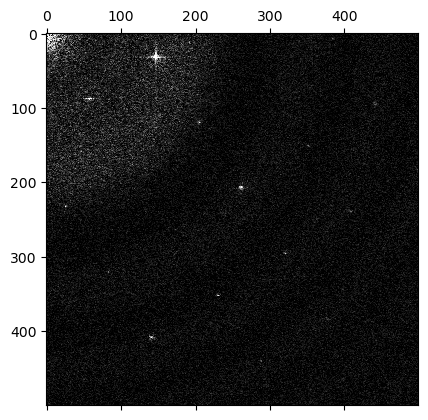

In [14]:
plt.matshow(np.log10(fft_avg)[:500, :500],
           cmap = "Greys_r",
           vmax = 2.4,
           vmin = 1.8)

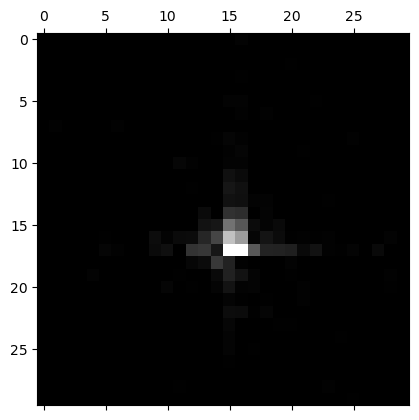

In [25]:
# Let's zoom in on a really bright spot and see what it looks like without smoothing.

plt.matshow(fft_avg[15:45, 132:162],
           cmap = "Greys_r",
           vmax = 2000,
           vmin = 100)

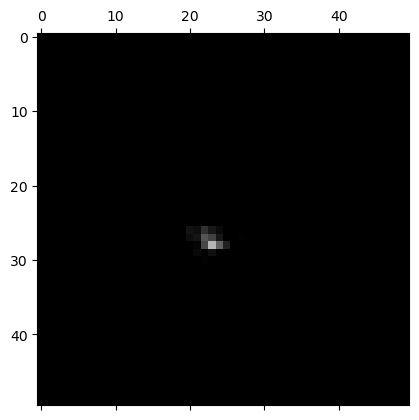

In [27]:
# And another.

plt.matshow(fft_avg[180:230, 240:290],
           cmap = "Greys_r",
           vmax = 1000,
           vmin = 100)

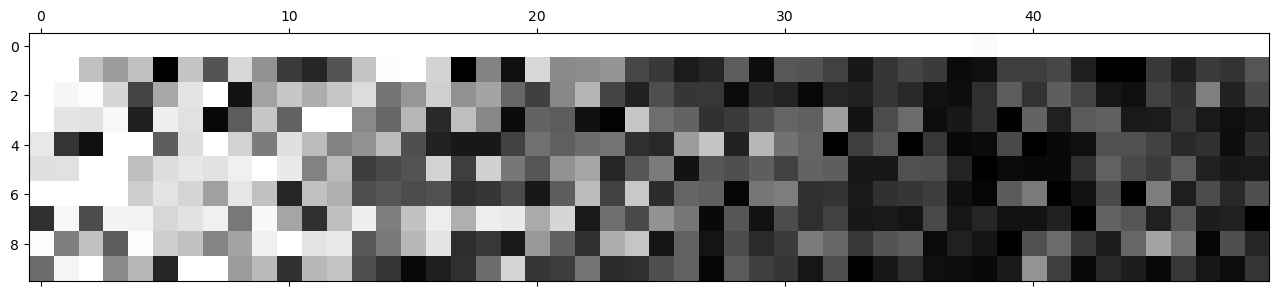

In [9]:
# Hey, looks like a bit of an artifact along axis0 = 0! We should set that to the value of the pixel below perhaps.
plt.matshow(np.log10(fft_avg)[:10, :50],
           cmap = "Greys_r",
           vmax = 2.4,
           vmin = 1.8)

In [ ]:
# The average of the spectra look promising. What happens if we sum the spectra?
# It looks basically the same, as expected.

In [ ]:
# Sum over the index axis of the array and plot
# fft_sum = np.sum(np.abs(big_array_fft), 2)

In [ ]:
# plt.matshow(np.log10(fft_sum)[:500, :500],
#            cmap = "Greys_r",
#            vmax = 4.6,
#            vmin = 3.4)

In [ ]:
# np.log10(fft_sum)[:500, :500]

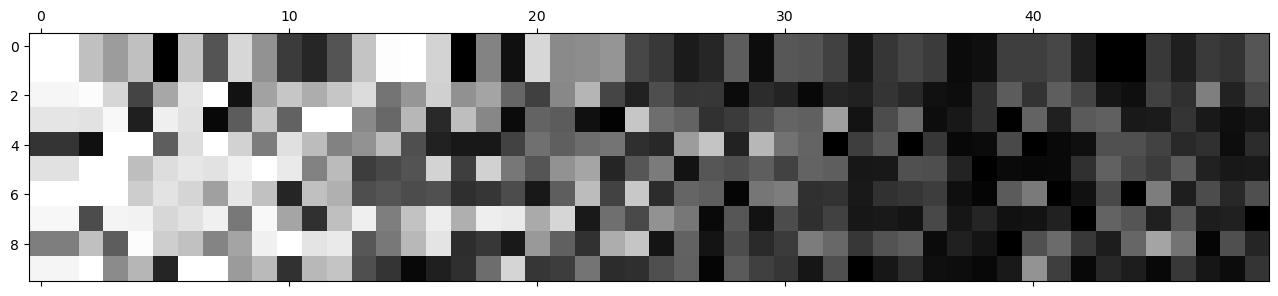

In [10]:
fft_artifact_mask = fft_avg
fft_artifact_mask[0,:] = fft_avg[1,:]
fft_artifact_mask[:,0] = fft_avg[:,1]

# The artifact is gone

plt.matshow(np.log10(fft_artifact_mask)[:10, :50],
           cmap = "Greys_r",
           vmax = 2.4,
           vmin = 1.8)

In [21]:
# Save the averaged FFT with the artifacts removed

np.save('fft_first_artifact_mask.npy', fft_artifact_mask)

In [11]:
# Smooth the power spectrum with Gaussian filter
fft_smoothed = gaussian(fft_artifact_mask, 9)
    
# Return the difference spectrum
fft_diff = fft_artifact_mask - fft_smoothed

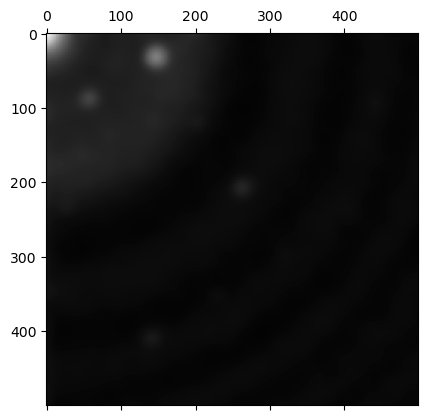

In [12]:
plt.matshow(np.log10(fft_smoothed)[:500, :500],
           cmap = "Greys_r",
           vmax = 2.4,
           vmin = 1.8)

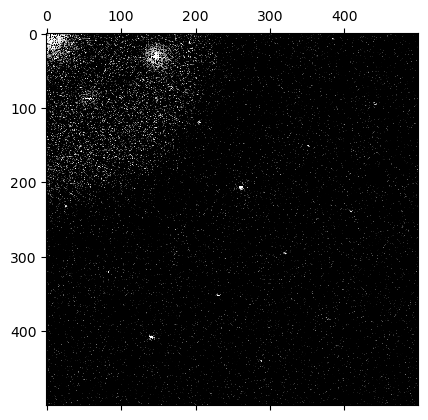

In [13]:
plt.matshow(np.log10(np.abs(fft_diff)+1)[:500, :500],
           cmap = "Greys_r",
           vmax = 1.75,
           vmin = 1)

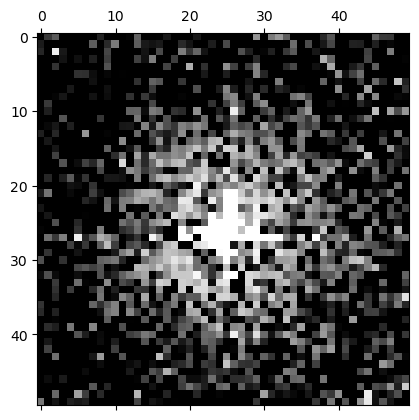

In [15]:
# What does a bright spot look like with smoothing?

plt.matshow(np.log10(np.abs(fft_diff)+1)[5:55, 122:172],
           cmap = "Greys_r",
           vmax = 1.75,
           vmin = 1)

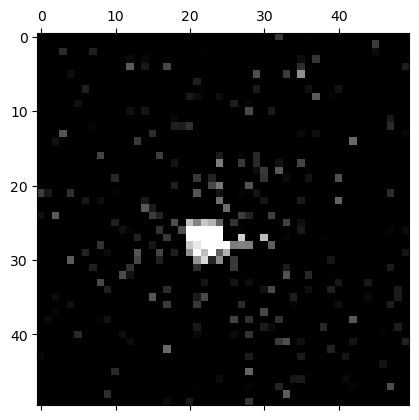

In [16]:
# What about another?

plt.matshow(np.log10(np.abs(fft_diff)+1)[180:230, 240:290],
           cmap = "Greys_r",
           vmax = 1.75,
           vmin = 1)

In [ ]:
# RESULT: If we take the average of the FFT of each movie frame, the spots come out cleaner.
# The Thon rings are fainter, so we don't need to do a Gaussian smoothing of the points.

In [17]:
# Now, let's pull out a 50x50 subset of data points around this point and fit to a Gaussian

np.where(fft_avg==np.max(fft_avg[180:230, 240:290]))

(array([208]), array([263]))

In [18]:
# Our point is (207, 262). Let's pull out a fitting subset.

fitting_subset = fft_avg[(207-25):(207+25),(262-25):(262+25)]

In [19]:
fitting_subset

array([[64.51183 , 62.13246 , 62.890385, ..., 64.40122 , 76.74438 ,
        69.71362 ],
       [64.78144 , 68.6906  , 65.205925, ..., 74.17912 , 65.9809  ,
        68.35439 ],
       [66.62485 , 63.909622, 67.729004, ..., 71.84493 , 63.069023,
        66.266106],
       ...,
       [60.776142, 76.84761 , 70.27374 , ..., 68.821724, 64.5332  ,
        69.56206 ],
       [55.819996, 71.31809 , 75.567696, ..., 64.7175  , 52.824387,
        71.4063  ],
       [61.553043, 69.63942 , 57.70713 , ..., 73.34886 , 64.93169 ,
        72.12475 ]], dtype=float32)

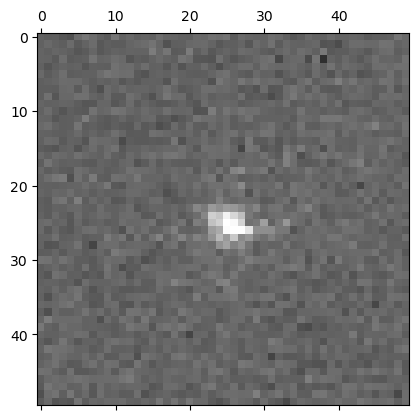

In [20]:
plt.matshow(np.log10(fitting_subset),
           cmap = "Greys_r",
           vmax = 2.5,
           vmin = 1.5)

# Fitting subset looks good and centered.

In [ ]:
# Generate axes

x = np.linspace(-24, 25, 50)
y = np.linspace(-24, 25, 50)
x, y = np.meshgrid(x, y)

In [ ]:
fitting_subset.shape

In [ ]:
def gaussian(x, y, A, a, b, C):
    value = A*np.exp(-(x**2/(2*a) + y**2/(2*b))) + C
    return value.ravel()

In [ ]:
gaussian(0, 0, 1000, 2, 3, 5)

In [ ]:
initial_guess = np.array([5000, 1, 1, 100])

In [ ]:
params, cov = curve_fit(gaussian, x, y, fitting_subset, p0=[5000, 1, 1, 100])